In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from ast import literal_eval
import sklearn as sk
import seaborn as sb
import re 
from tqdm import tqdm

import torch
import torchvision

c:\Users\nikla\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def initialize_data():
    data = pd.read_csv("data/df_text_spacy.csv")
    data2 = pd.read_csv("data/train_500.csv")
    data2 = data2[["gender", "age", "topic", "sign"]]
    data = data.join(data2)
    data = data.drop(["Unnamed: 0"], axis=1)
    data = data.replace({"male": 0, "female": 1})

    data['sent_tokenize'] = data.apply(lambda row: sent_tokenize(row['text']), axis=1)
    data['word_tokenize'] = data.apply(lambda row: word_tokenize(row['text']), axis=1)
    data['sentence_count'] = data.apply(lambda row: len(row['sent_tokenize']), axis=1)
    data['word_count'] = data.apply(lambda row: len(literal_eval(row['text_list'])), axis=1)

    return data

In [3]:
data = initialize_data()

In [4]:
data["gender"].value_counts()

0    11002
1     8498
Name: gender, dtype: int64

In [5]:
data_male = data[data["gender"] == 0]
data_male.reset_index(inplace=True)
#data_male.drop("Unnamed: 0", axis=1, inplace=True)

data_female = data[data["gender"] == 1]
data_female.reset_index(inplace=True)
#data_female.drop("Unnamed: 0", axis=1, inplace=True)



In [6]:
data_male.describe()

,index,lemma_list_num_of_stopwords,gender,age,sentence_count,word_count
count,11002.000000,11002.000000,11002.0,11002.000000,11002.000000,11002.000000
mean,9552.282131,60.428104,0.0,26.626795,8.025904,165.652972
std,5507.777844,59.201220,0.0,7.814512,7.483871,155.327601
min,0.000000,0.000000,0.0,13.000000,1.000000,1.000000
25%,4868.250000,14.000000,0.0,23.000000,2.000000,43.000000
50%,9412.500000,41.000000,0.0,25.000000,5.000000,117.000000
75%,14289.750000,89.000000,0.0,33.000000,12.000000,241.000000
max,19498.000000,312.000000,0.0,48.000000,33.000000,745.000000


In [7]:
data_female.describe()

,index,lemma_list_num_of_stopwords,gender,age,sentence_count,word_count
count,8498.000000,8498.000000,8498.0,8498.000000,8498.000000,8498.000000
mean,10004.829607,67.045775,1.0,26.308426,8.894681,184.632619
std,5773.185314,59.608547,0.0,7.289428,7.894702,156.490219
min,2.000000,0.000000,1.0,13.000000,1.000000,2.000000
25%,4886.500000,18.000000,1.0,23.000000,2.000000,56.000000
50%,10387.000000,50.000000,1.0,25.000000,6.000000,144.000000
75%,15064.500000,101.000000,1.0,27.000000,13.000000,276.000000
max,19499.000000,319.000000,1.0,48.000000,33.000000,777.000000


<AxesSubplot:xlabel='word_count', ylabel='Count'>

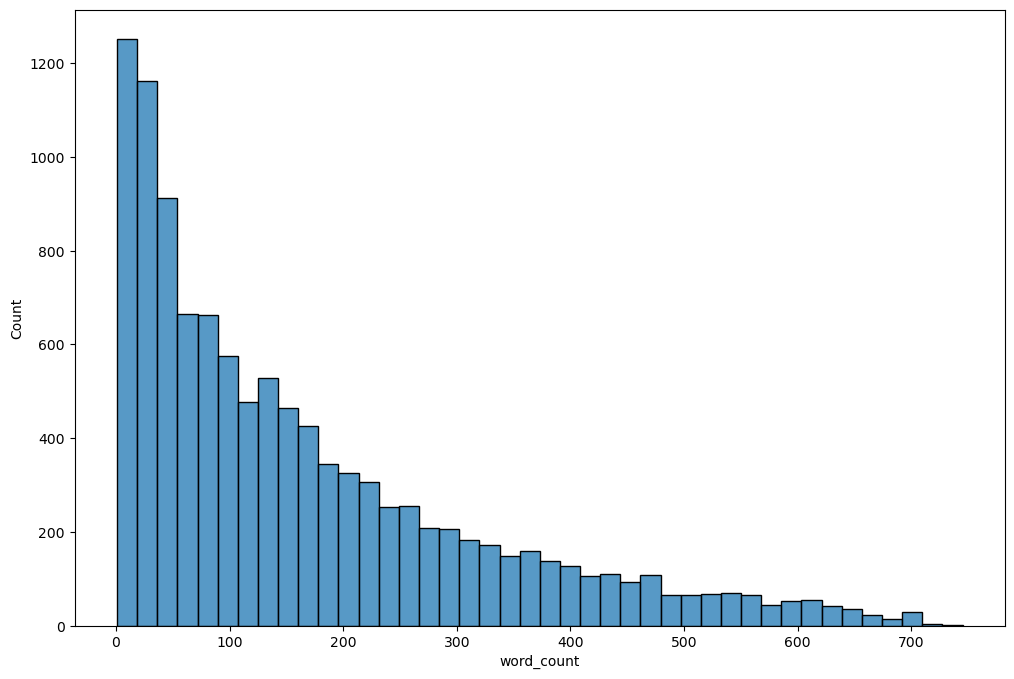

In [8]:
plt.figure(figsize=(12,8))
sb.histplot(x="word_count", data=data_male)

<AxesSubplot:xlabel='word_count', ylabel='Count'>

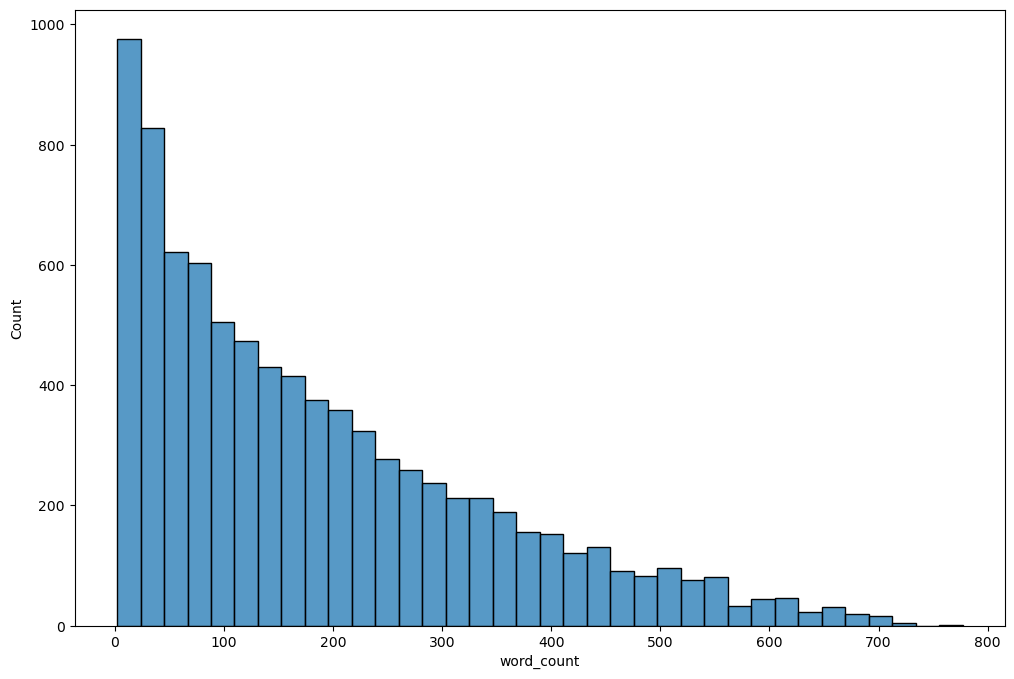

In [9]:
plt.figure(figsize=(12,8))
sb.histplot(x="word_count", data=data_female)

<AxesSubplot:xlabel='word_count', ylabel='Count'>

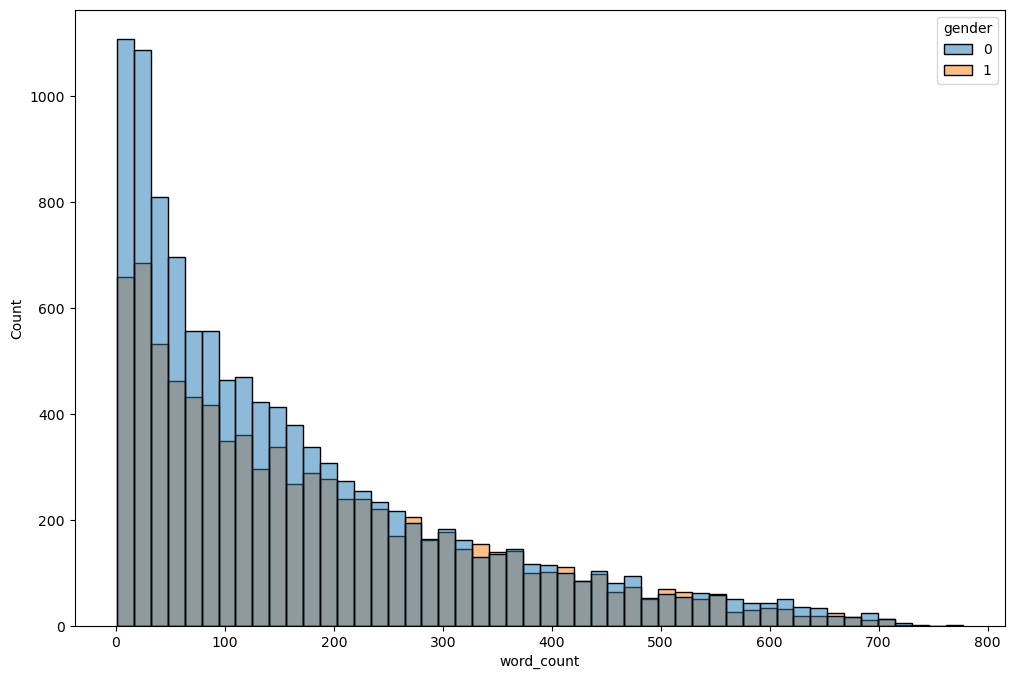

In [12]:
plt.figure(figsize=(12,8))
sb.histplot(x="word_count", data=data, hue="gender")

<AxesSubplot:xlabel='sentence_count', ylabel='Count'>

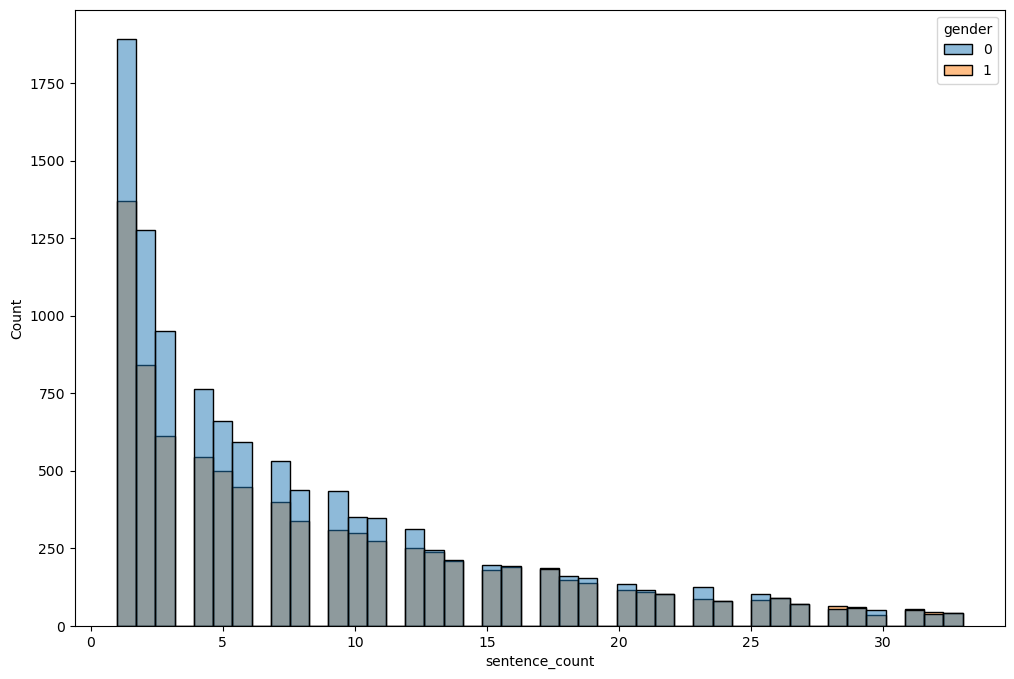

In [11]:
plt.figure(figsize=(12,8))
sb.histplot(x="sentence_count", data=data, hue="gender")

In [13]:
data.head(2)

,text,text_list,lemma_list,pos_list,tag_list,dep_list,shape_list,alpha_list,stop_list,lemma_list_num_of_stopwords,...,data_lemmatized_noun,text_out_list_noun,gender,age,topic,sign,sent_tokenize,word_tokenize,sentence_count,word_count
0,This blog is being posted due to the fact that...,"['This', 'blog', 'is', 'being', 'posted', 'due...","['this', 'blog', 'be', 'be', 'post', 'due', 't...","['DET', 'NOUN', 'AUX', 'AUX', 'VERB', 'ADP', '...","['DT', 'NN', 'VBZ', 'VBG', 'VBN', 'IN', 'IN', ...","['det', 'nsubjpass', 'aux', 'auxpass', 'ROOT',...","['Xxxx', 'xxxx', 'xx', 'xxxx', 'xxxx', 'xxx', ...","[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, True, True, T...",34,...,fact development regard day school uniform swa...,"['fact', 'development', 'regard', 'day', 'scho...",0,14,Student,Sagittarius,[This blog is being posted due to the fact tha...,"[This, blog, is, being, posted, due, to, the, ...",4,91
1,So I have a big fucking interview tomorrow for...,"['So', 'I', 'have', 'a', 'big', 'fucking', 'in...","['so', '-PRON-', 'have', 'a', 'big', 'fucking'...","['CCONJ', 'PRON', 'AUX', 'DET', 'ADJ', 'ADJ', ...","['CC', 'PRP', 'VBP', 'DT', 'JJ', 'JJ', 'NN', '...","['advmod', 'nsubj', 'ROOT', 'det', 'amod', 'am...","['Xx', 'X', 'xxxx', 'x', 'xxx', 'xxxx', 'xxxx'...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, False, False, False, ...",32,...,interview tomorrow school talk people girl spo...,"['interview', 'tomorrow', 'school', 'talk', 'p...",0,15,Student,Pisces,[So I have a big fucking interview tomorrow fo...,"[So, I, have, a, big, fucking, interview, tomo...",5,88


In [14]:
def create_word_dict(data, without_stopwords=True, with_stopwords=False):

    if without_stopwords:
        word_dict_without_stopwords = {}
        
    if with_stopwords:
        word_dict_with_stopwords = {}

    stopword_list = stopwords.words('english')
    for i in tqdm(range(len(data))):
        if without_stopwords:
            for word in literal_eval(data["lemma_list"][i]):
                if word not in [",", ".", ")", "(", "{", "}", "[", "]", ":", ";", "\"\"", "...", "I", "-PRON-", "-", "'", "'s", "urllink"] and word not in stopword_list:
                    if word in word_dict_without_stopwords.keys():
                        word_dict_without_stopwords[word] += 1
                    else:
                        word_dict_without_stopwords[word] = 1

        if with_stopwords:
            for word in literal_eval(data["word_tokenize"][i]):
                if word not in [",", ".", ")", "(", "{", "}", "[", "]", ":", ";", "\"\"", "...", "I", "-PRON-", "-", "'"]:
                    if word in word_dict_with_stopwords.keys():
                        word_dict_with_stopwords[word] += 1
                    else:
                        word_dict_with_stopwords[word] = 1

    if without_stopwords and with_stopwords:
        return word_dict_without_stopwords, word_dict_with_stopwords
    elif without_stopwords:
        return word_dict_without_stopwords
    elif with_stopwords:
        return word_dict_with_stopwords
    else:
        print("Nothing to return selected")
        return 0

In [15]:
words_without_stopwords_all = create_word_dict(data, True, False)
words_without_stopwords_male = create_word_dict(data_male, True, False)
words_without_stopwords_female = create_word_dict(data_female, True, False)

100%|██████████| 8498/8498 [00:03<00:00, 2638.21it/s]


In [16]:
def visualize_specific_words(dictionary, limit=10, save_fig=True, save_name="standard_save_name"):
    data_as_df = pd.DataFrame(data={"word": dictionary.keys(), "number": dictionary.values()})
    sorted_df = data_as_df.sort_values(by="number", ascending=False)

    figure = sb.barplot(data=sorted_df[:limit], x="word", y="number", palette="deep")
    figure.set_xlabel("Words")
    figure.set_ylabel("Appearances of the word")

    if save_fig:
        fig = figure.get_figure()
        fig.savefig(str(save_name + ".jpg"))

    return fig.get_figure()

UnboundLocalError: local variable 'fig' referenced before assignment

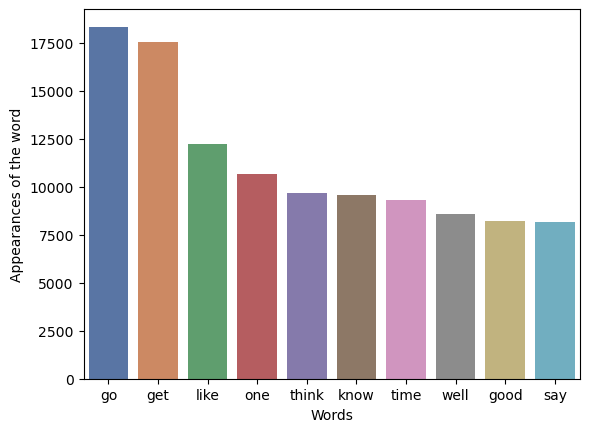

In [17]:
figure_1 = visualize_specific_words(words_without_stopwords_all, save_fig=False)

UnboundLocalError: local variable 'fig' referenced before assignment

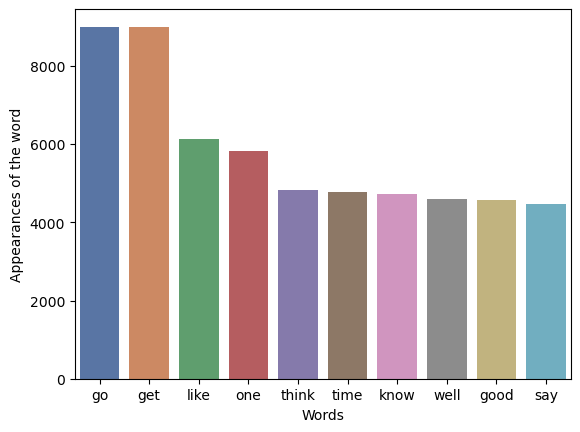

In [18]:
figure_2 = visualize_specific_words(words_without_stopwords_male, save_fig=False)

UnboundLocalError: local variable 'fig' referenced before assignment

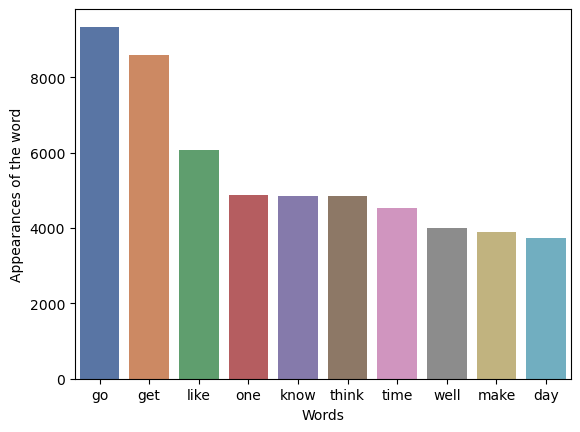

In [19]:
figure_3 = visualize_specific_words(words_without_stopwords_female, save_fig=False)

In [20]:
data.head(2)

,text,text_list,lemma_list,pos_list,tag_list,dep_list,shape_list,alpha_list,stop_list,lemma_list_num_of_stopwords,...,data_lemmatized_noun,text_out_list_noun,gender,age,topic,sign,sent_tokenize,word_tokenize,sentence_count,word_count
0,This blog is being posted due to the fact that...,"['This', 'blog', 'is', 'being', 'posted', 'due...","['this', 'blog', 'be', 'be', 'post', 'due', 't...","['DET', 'NOUN', 'AUX', 'AUX', 'VERB', 'ADP', '...","['DT', 'NN', 'VBZ', 'VBG', 'VBN', 'IN', 'IN', ...","['det', 'nsubjpass', 'aux', 'auxpass', 'ROOT',...","['Xxxx', 'xxxx', 'xx', 'xxxx', 'xxxx', 'xxx', ...","[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, True, True, T...",34,...,fact development regard day school uniform swa...,"['fact', 'development', 'regard', 'day', 'scho...",0,14,Student,Sagittarius,[This blog is being posted due to the fact tha...,"[This, blog, is, being, posted, due, to, the, ...",4,91
1,So I have a big fucking interview tomorrow for...,"['So', 'I', 'have', 'a', 'big', 'fucking', 'in...","['so', '-PRON-', 'have', 'a', 'big', 'fucking'...","['CCONJ', 'PRON', 'AUX', 'DET', 'ADJ', 'ADJ', ...","['CC', 'PRP', 'VBP', 'DT', 'JJ', 'JJ', 'NN', '...","['advmod', 'nsubj', 'ROOT', 'det', 'amod', 'am...","['Xx', 'X', 'xxxx', 'x', 'xxx', 'xxxx', 'xxxx'...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, False, False, False, ...",32,...,interview tomorrow school talk people girl spo...,"['interview', 'tomorrow', 'school', 'talk', 'p...",0,15,Student,Pisces,[So I have a big fucking interview tomorrow fo...,"[So, I, have, a, big, fucking, interview, tomo...",5,88


In [21]:
def getNumbers(data):
    data["num_nouns"] = 0
    data["num_verbs"] = 0
    data["num_conjs"] = 0
    num_nouns, num_verbs, num_conjs = [], [], []

    for i in tqdm(range(len(data))):
        nouns, verbs, conjs = 0, 0, 0
        for elem in literal_eval(data["pos_list"][i]):
            #print(elem)
            if elem == "NOUN":
                nouns += 1
            elif elem == "VERB":
                verbs += 1
            elif elem == "CCONJ":
                conjs += 1
        num_nouns.append(nouns)
        num_verbs.append(verbs)
        num_conjs.append(conjs)

    data["num_nouns"] = num_nouns
    data["num_verbs"] = num_verbs
    data["num_conjs"] = num_conjs

    return data

def getRatios(data):
    data["ratio_nouns"] = data.apply(lambda row: (row["num_nouns"] / row["word_count"]), axis=1)
    data["ratio_verbs"] = data.apply(lambda row: (row["num_verbs"] / row["word_count"]), axis=1)
    data["ratio_conjs"] = data.apply(lambda row: (row["num_conjs"] / row["word_count"]), axis=1)

    return data

In [22]:
#data['word_tokenize'] = data.apply(lambda row: word_tokenize(row['text']), axis=1)
data = getNumbers(data)
data = getRatios(data)


100%|██████████| 19500/19500 [00:03<00:00, 5366.64it/s]


In [23]:
data.head(2)

,text,text_list,lemma_list,pos_list,tag_list,dep_list,shape_list,alpha_list,stop_list,lemma_list_num_of_stopwords,...,sent_tokenize,word_tokenize,sentence_count,word_count,num_nouns,num_verbs,num_conjs,ratio_nouns,ratio_verbs,ratio_conjs
0,This blog is being posted due to the fact that...,"['This', 'blog', 'is', 'being', 'posted', 'due...","['this', 'blog', 'be', 'be', 'post', 'due', 't...","['DET', 'NOUN', 'AUX', 'AUX', 'VERB', 'ADP', '...","['DT', 'NN', 'VBZ', 'VBG', 'VBN', 'IN', 'IN', ...","['det', 'nsubjpass', 'aux', 'auxpass', 'ROOT',...","['Xxxx', 'xxxx', 'xx', 'xxxx', 'xxxx', 'xxx', ...","[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, True, True, T...",34,...,[This blog is being posted due to the fact tha...,"[This, blog, is, being, posted, due, to, the, ...",4,91,17,15,1,0.186813,0.164835,0.010989
1,So I have a big fucking interview tomorrow for...,"['So', 'I', 'have', 'a', 'big', 'fucking', 'in...","['so', '-PRON-', 'have', 'a', 'big', 'fucking'...","['CCONJ', 'PRON', 'AUX', 'DET', 'ADJ', 'ADJ', ...","['CC', 'PRP', 'VBP', 'DT', 'JJ', 'JJ', 'NN', '...","['advmod', 'nsubj', 'ROOT', 'det', 'amod', 'am...","['Xx', 'X', 'xxxx', 'x', 'xxx', 'xxxx', 'xxxx'...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, False, False, False, ...",32,...,[So I have a big fucking interview tomorrow fo...,"[So, I, have, a, big, fucking, interview, tomo...",5,88,12,13,2,0.136364,0.147727,0.022727


<function matplotlib.pyplot.show(close=None, block=None)>

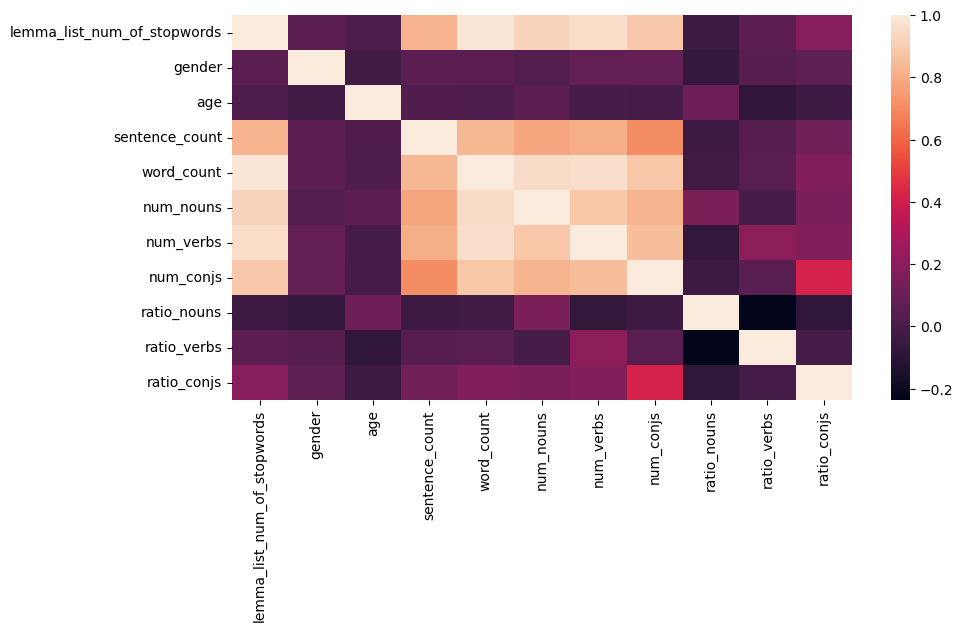

In [24]:
plt.figure(figsize=(10,5))
sb.heatmap(data.corr())
plt.show

In [25]:
from transformers import pipeline, AutoTokenizer

In [26]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenizer_function(input_string, padding=True, truncation=True, return_tensors="pt"):
    return tokenizer(input_string, padding=padding, truncation=truncation, return_tensors=return_tensors)

In [27]:
data["tok"] = 0
for i in tqdm(range(len(data))):
    data["tok"][i] = tokenizer_function(data["text"][i])


  0%|          | 0/19500 [00:00<?, ?it/s]C:\Users\nikla\AppData\Local\Temp\ipykernel_8652\2452050011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["tok"][i] = tokenizer_function(data["text"][i])
100%|██████████| 19500/19500 [00:07<00:00, 2520.96it/s]


In [28]:
data["tok"][1]["input_ids"]

tensor([[  101,  2061,  1045,  2031,  1037,  2502,  8239,  4357,  4826,  2005,
          2026,  2047,  2082,  1012,  1045,  2572,  2036,  6015,  1997,  3331,
          2000,  2111,  2008,  1045,  2123,  1005,  1056,  2113,  2164,  3057,
          1012,  2061,  2008,  1005,  1055,  2183,  2000,  2404,  2033,  1999,
          1037,  2919,  3962,  1012,  1998,  1045,  4687,  2054,  3980,  2008,
          2027,  1005,  2222,  3198,  1012,  2009,  1005,  1055,  2763,  2242,
          2066,  1024,  1011,  2339,  2106,  2017,  6611,  2000, 12997,  7898,
          1011,  2013,  2115,  2034,  3193,  2054, 19802, 22139,  2015, 12997,
          7898,  2013,  2151,  2060,  2082,  1011,  2097,  2017,  2022,  2478,
          1996, 20116,  2226, 13433, 21781,  3075,  2411,  2151,  2393,  2065,
          2017,  2064,   102]])

In [29]:
small_train_dataset = data[data.index <= (len(data)*0.75)]
small_test_dataset = data[data.index > (len(data)*0.75)]

small_train_dataset = small_train_dataset.rename(columns={"gender": "labels", "tok": "logits"})
small_test_dataset = small_test_dataset.rename(columns={"gender": "labels", "tok": "logits"})

In [30]:
small_train_dataset = small_train_dataset[["labels", "logits"]].to_dict()
small_test_dataset = small_test_dataset[["labels", "logits"]].to_dict()

In [31]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from torch import nn

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
DLL load failed while importing lib: Die angegebene Prozedur wurde nicht gefunden.

In [27]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 2)

Downloading: 100%|██████████| 570/570 [00:00<00:00, 378kB/s]
Downloading: 100%|██████████| 436M/436M [00:40<00:00, 10.8MB/s] 
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSe

In [32]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
metric = evaluate.load("accuracy")

In [31]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [48]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [49]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = small_train_dataset,
    eval_dataset = small_test_dataset,
    compute_metrics = compute_metrics,
)

In [52]:
trainer.train()

***** Running training *****
  Num examples = 2
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3
  Number of trainable parameters = 108311810


  0%|          | 0/3 [00:23<?, ?it/s]


KeyError: 0